In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.time import Time
import sys

from tqdm import *

%matplotlib inline

In [3]:
def ReadPulselist(f, SNcut=1, phase0=0.5, phasewidth=0.5):
    T, SN, phase = np.loadtxt(f, dtype='string').T
    
    T = Time(T, precision=9)

    # Remove duplicates
    Tu, indeces = np.unique(T.isot, return_index=True)

    T = Time(Tu, precision=9)
    SN = SN[indeces].astype('float')
    phase = phase[indeces].astype('float')

    # Take only pulses of sufficient S/N
    T = T[SN>SNcut]
    phase = phase[SN>SNcut]
    SN = SN[SN>SNcut]

    # Take only pulses of a certain phase range
    T = T[abs(phase-phase0) < phasewidth]
    SN = SN[abs(phase-phase0) < phasewidth]
    phase = phase[abs(phase-phase0) < phasewidth]

    return T, SN, phase

def ExtractPulse(tgp):
    # Read pulse, numpy array of [time, freq, pol]
    dchan = np.load('/mnt/scratch-lustre/ramain/CrabGPs/GP{0}.npy'.format(tgp.isot))
    
    # Reorder in frequency and combine L, R polarizations
    dR = np.concatenate((dchan[:,::-1,2][:,:-1], dchan[...,0][:,1:]), axis=1)
    dL = np.concatenate((dchan[:,::-1,3][:,:-1], dchan[...,1][:,1:]), axis=1)
    x = (abs(dR)**2 + abs(dL)**2)
    
    # Choose bin where the pulse is brightest
    pulse = x[50]
    
    # Choose off-pulse region to get background measurement
    noise = x[5:35]#.mean(0)

    return pulse[16:-16], noise[:,16:-16]

def FreqCorr_roll(GP1, N1, GP2, N2):
    N = len(GP1)
    ccorr = np.zeros(N)
    # sigma for correlation coefficient is sigma_on^2 - sigma_off^2
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    # Roll along frequency, calculate correlation coeff for each freq. shift
    for i in range(N):
        GP2roll = np.roll(GP2, i)
        autoc = (GP1 - np.mean(GP1))  * (GP2roll - np.mean(GP2))
        corr = np.mean( autoc / np.sqrt(std1 * std2))        
        ccorr[i] = corr 
    return ccorr
    
def FreqCorr_FFT(GP1, N1, GP2, N2):
    # Same as Freq_Corr_roll, but used FFTs instead of np roll
    N = len(GP1)
    ccorr = np.zeros(N)
    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    autoc = np.fft.irfft( np.fft.rfft(GP1 - np.mean(GP1))  * np.fft.rfft(GP2 - np.mean(GP2)).conj() )
    ccorr = autoc / np.sqrt(std1 * std2) / N
    return ccorr
    


In [26]:
""" Begin by taking all pairs of pulses """
Tcut = 60
Tbin = 1
#SNcut = 16
SNcut = 50

# pulse pist, time, SN, phase
gplist = '/mnt/scratch-lustre/ramain/CrabGPs/gp_SN16.txt'
T, SN, phase = ReadPulselist(gplist, SNcut=SNcut, phase0=0.73, phasewidth=0.02)  #MP pairs

l = len(T)
pairDT = np.zeros(l*l)
# Create an array of unix times
Tu = T.unix

DTu = []

# Create array with time difference of each pulse
for i in range(l):
    for j in range(l):
        diff = Tu[i] - Tu[j]
        pairDT[i*l+j] = diff

# Cross-correlate each pair of pulses separated bu less than Tcut, store in array ccorr
for i in tqdm(range(l)):
    GP1, N1 = ExtractPulse(T[i])
    for j in range(l):
        if np.abs(pairDT[i*l+j]) < Tcut:
            GP2, N2 = ExtractPulse(T[j])
            ccorr_temp = FreqCorr_FFT(GP1, N1, GP2, N2)
            if i == 0 and j == 0:
                ccorr = ccorr_temp[np.newaxis,:]
            else:
                ccorr = np.concatenate((ccorr,ccorr_temp[np.newaxis,:]), axis=0)
            DTu.append(pairDT[i*l+j])
            
DTu = np.array(DTu)

100%|██████████| 1403/1403 [01:25<00:00, 16.35it/s]


(13999, 224) (13999, 224) (13999,)


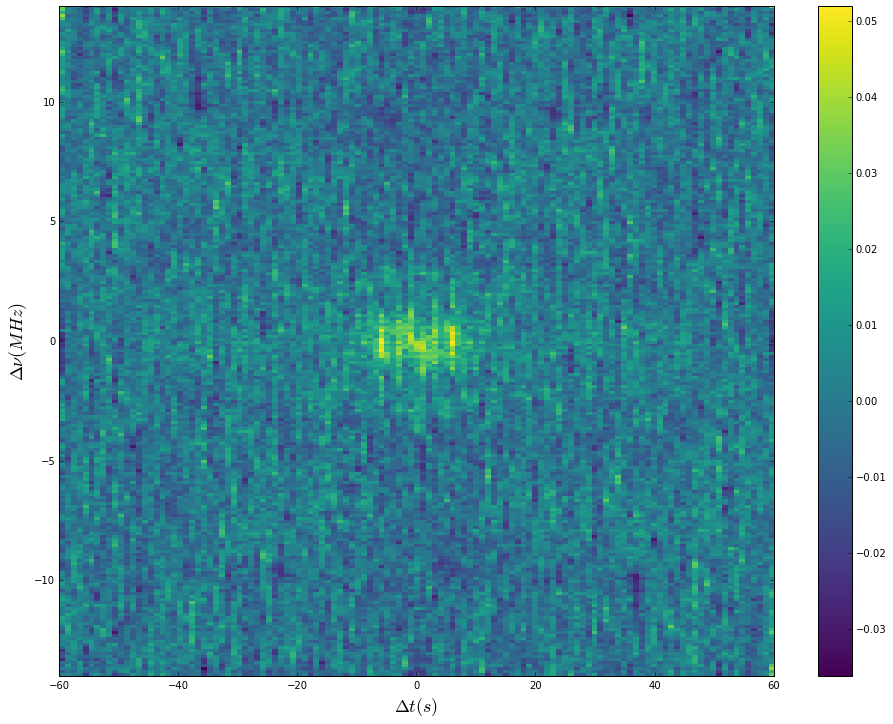

In [40]:
# Bin every second
%matplotlib inline

Tbin = 1
ccorru = np.array(ccorr)

DTplot = []
Cplot = []
CCplot = []
Cerr = []

# Average correlations in each bin of dt
for i in range(-int(Tcut / Tbin), int(Tcut / Tbin)+1):
    if i == 0:
        indeces = np.argwhere( abs(DTu-(i*Tbin+Tbin/2.)) < Tbin/2.-0.01 ).squeeze()
    else:
        indeces = np.argwhere( (DTu-i*Tbin > -Tbin/2.) & (DTu-i*Tbin < Tbin/2.) ).squeeze()
    DTrange = DTu[indeces]
    ccrange = ccorru[indeces]
    ccrange = ccrange[np.argwhere(~np.isnan(ccrange.sum(-1)))].squeeze()
    CCplot.append(np.mean(ccrange, axis=0) )

CCplot = np.array(CCplot)
# Roll by half to center d_nu
CCplot = np.roll(CCplot, CCplot.shape[1]/2, axis=1)

# Subtract by region where there is no signal to remove the bandpass correlation
CCplot_clean = CCplot - CCplot[:20].mean(0)/2 - CCplot[-20:].mean(0)/2

plt.figure(figsize=(16,12))
plt.imshow(CCplot_clean.T, aspect='auto', interpolation='nearest',
          extent=[-60,60,-14,14])
plt.xlabel(r'$\Delta t (s)$', fontsize=18)
plt.ylabel(r'$\Delta \nu (MHz)$', fontsize=18)
plt.colorbar()

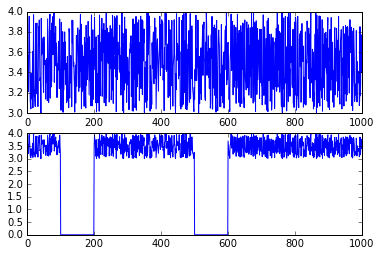

In [6]:
x = np.random.random(1000) + 3

plt.subplot(211)
plt.plot(x)

mask1 = slice(100,200)
mask2 = slice(500,600)

x[mask1] = 0
x[mask2] = 0

plt.subplot(212)

plt.plot(x)

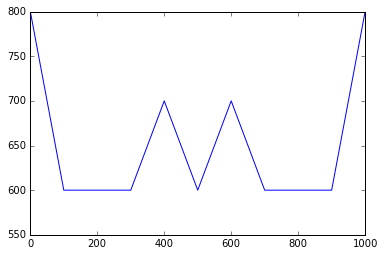

In [9]:
binmask = np.array(x)
binmask[binmask != 0] = 1

#plt.plot(binmask)

maskcorr = np.fft.irfft( np.fft.rfft(binmask)  * np.fft.rfft(binmask).conj() )

plt.plot(maskcorr)

In [12]:
from pulsar.predictor import Polyco

t0 = Time('2015-10-19T00:00:00')
t_gp = Time('2015-10-19T00:54:59.880')
polyco = Polyco('/home/ramain/packages/scint_analysis/EVN_crab/oct_polycob0531_eff.dat')

phase_pol = polyco.phasepol(t0)
ef_phase = np.remainder(phase_pol(t_gp.mjd), 1)

print ef_phase

0.122399434447


/usr/local/lib/python2.7/dist-packages/astropy/table/column.py:331: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return super(BaseColumn, self).__getitem__(item)
